In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!sudo apt install tesseract-ocr
!pip install pytesseract
!sudo apt-get install tesseract-ocr-eng
!sudo apt-get install tesseract-ocr-tha


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 8 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr-eng is already the newest version (1:4.00~git30-7274cfa-1.1).
0 upgraded, 0 newly installed, 0 to remove and 8 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr-tha is already the newest version (1:4.00~git30-7274cfa-1.1).
0 upgraded, 0 newly installed, 0 to remove and 8 not upgraded.


In [ ]:
# Essential Imports
import cv2
import pytesseract
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sqlite3
from datetime import date
import os
import shutil

In [ ]:
#(1141, 509, 529, 132)

# ( x start , y start, x end , y end)

#My custom class for declare region of interest.
class ImageConstantROI():
    class CCCD(object):
        ROIS = {
            "id": [(1271, 153, 1020, 120)],
            "name": [(1141, 509, 800, 132),(1327, 634, 751, 155),],
            "thai_name": [(1087, 294, 1316, 236)],
            "birth_date": [(1463, 929, 652, 130)],
            "address": [(458, 1193, 1578, 141),(276, 1320, 1229, 138)],
            "date_of_issue": [(288, 1628, 430, 81)],
            "date_expire": [(1640, 1624, 460, 99)],
        }

        CHECK_ROI = [(313, 174, 597, 63)]

#Custom function to show open cv image on notebook.
def display_img(cvImg):
    cvImg = cv2.cvtColor(cvImg, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10,8))
    plt.imshow(cvImg)
    plt.axis('off')
    plt.show()

In [ ]:
#Loading image using cv2
# baseImg = cv2.imread('/content/drive/MyDrive/document/test/national_id_card/or.jpg')

#Declare image size, width height and chanel
baseH, baseW, baseC = baseImg.shape

# display_img(baseImg)

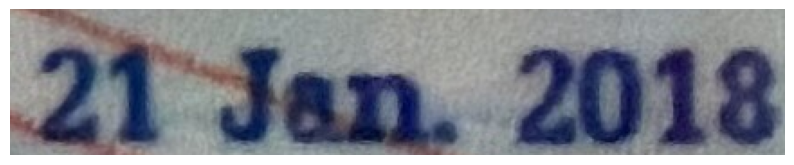

In [ ]:
#Create a custom function to cropped image base on religion of interest
def cropImageRoi(image, roi):
    roi_cropped = image[
        int(roi[1]) : int(roi[1] + roi[3]), int(roi[0]) : int(roi[0] + roi[2])
    ]
    return roi_cropped

testCrop = cropImageRoi(baseImg, ImageConstantROI.CCCD.ROIS['date_of_issue'][0])
display_img(testCrop)

In [ ]:
def preprocessing_image(img):

    # Display original image
    # print("Original Image:")
    # display_img(img)

    # Resize image
    # img = cv2.resize(img, None, fx=1.5, fy=1.5, interpolation=cv2.INTER_CUBIC)
    # If you decide to uncomment the resize, display the image after this step

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # print("\nGrayscale Image:")
    # display_img(gray)

    # Adjust the intensity of the grayscale image
    gray = cv2.multiply(gray, 1)
    # print("\nAdjusted Intensity Image:")
    # display_img(gray)

    return gray

    # # Blur to remove noise
    # blured1 = cv2.medianBlur(gray,3)
    # blured2 = cv2.medianBlur(gray,51)
    # divided = np.ma.divide(blured1, blured2).data
    # normed = np.uint8(255*divided/divided.max())

    # # Display the normalized image
    # print("\nNormalized Image:")
    # display_img(normed)

    # # Threshold the image
    # th, threshed = cv2.threshold(normed, 0, 255, cv2.THRESH_OTSU + cv2.THRESH_BINARY)
    # print("\nThresholded Image:")
    # display_img(threshed)

    # return threshed

testPreprocess = preprocessing_image(testCrop)


In [ ]:
#Extract data from cropped image
pytesseract.image_to_string(testCrop, config='-l tha+eng --oem 1 --psm 6')

'21 Jan. 2018\n\x0c'

In [ ]:
MODEL_CONFIG = '-l tha+eng --oem 1 --psm 6'
#NO_PREPROCESSING_CATEGORIES = {'id','name','date_expire', 'date_of_issue', 'address', 'birth_date', 'thai_name'}
NO_PREPROCESSING_CATEGORIES = {}

for key, roi in ImageConstantROI.CCCD.ROIS.items():
    extracted_data = []

    for r in roi:
        crop_img = cropImageRoi(baseImg, r)

        # Apply preprocessing only if the key is not in the set of no preprocessing categories
        if key not in NO_PREPROCESSING_CATEGORIES:
            crop_img = preprocessing_image(crop_img)

        display_img(crop_img)

        extracted_text = pytesseract.image_to_string(crop_img, config=MODEL_CONFIG)
        extracted_data.append(extracted_text.strip())

    print(f"{key} : {' '.join(extracted_data)}")


In [ ]:

#NO_PREPROCESSING_CATEGORIES = {'id','name','date_expire', 'date_of_issue', 'address', 'birth_date', 'thai_name'}
NO_PREPROCESSING_CATEGORIES = {}
def extractDataFromIdCard(img):
    extracted_data_dict = {}

    for key, roi in ImageConstantROI.CCCD.ROIS.items():
        data_strings = []

        for r in roi:
            crop_img = cropImageRoi(img, r)

            # Apply preprocessing if the key is not in the set of no preprocessing categories
            if key not in NO_PREPROCESSING_CATEGORIES:
                crop_img = preprocessing_image(crop_img)

            #display_img(crop_img)

            # Extract data from image using pytesseract
            extracted_text = pytesseract.image_to_string(crop_img, config=MODEL_CONFIG)
            data_strings.append(extracted_text.strip())

        extracted_data = ' '.join(data_strings)
        extracted_data_dict[key] = extracted_data
        print(f"{key} : {extracted_data}")

    return extracted_data_dict


In [ ]:
# Define constants
DB_FILE = 'result_id.db'
TABLE_NAME = 'id_data'

def initialize_database():
    """
    Initializes (or connects to) an SQLite database.
    Creates a table if it does not exist.
    """
    conn = sqlite3.connect(DB_FILE)
    c = conn.cursor()

    # Create a table to store extracted ID data
    c.execute(f'''CREATE TABLE IF NOT EXISTS {TABLE_NAME} (
                    file_name TEXT PRIMARY KEY,
                    id TEXT,
                    name TEXT,
                    thai_name TEXT,
                    birth_date TEXT,
                    address TEXT,
                    date_of_issue TEXT,
                    date_expire TEXT,
                    extraction_date DATE)''')
    conn.commit()
    conn.close()

def insert_data_to_db(file_name, data):
    """
    Inserts extracted data into the database.
    """
    conn = sqlite3.connect(DB_FILE)
    c = conn.cursor()

    # Insert or replace data based on file name as the primary key
    c.execute(f"INSERT OR REPLACE INTO {TABLE_NAME} VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?)",
              (file_name, data.get("id", ""), data.get("name", ""),
               data.get("thai_name", ""), data.get("birth_date", ""),
               data.get("address", ""), data.get("date_of_issue", ""),
               data.get("date_expire", ""), date.today()))
    conn.commit()
    conn.close()


In [ ]:
# Path to your image directory
IMG_DIR = '/content/drive/MyDrive/document/test/national_id_card/'

# If the database file exists, delete it
if os.path.exists(DB_FILE):
    os.remove(DB_FILE)

# Initialize the database (creates table if it doesn't exist)
initialize_database()

# Initialize the database (creates table if it doesn't exist)
sift = cv2.SIFT_create()

for img_file in os.listdir(IMG_DIR):
    img_path = os.path.join(IMG_DIR, img_file)
    if not os.path.isfile(img_path):
        continue

    # Load the image
    img2 = cv2.imread(img_path)

    # Detect keypoints and descriptors on base Image and img2
    kp, des = sift.detectAndCompute(baseImg, None)
    kp1, des1 = sift.detectAndCompute(img2, None)

    # Init BF Matcher with cross checking and find the matches points of two images
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1, des, k=2)


    # Lowe's ratio test
    good_matches = [m for m, n in matches if m.distance < 0.70 * n.distance]

    # Extracting location of good matched keypoints
    srcPoints = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    dstPoints = np.float32([kp[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

    # Find homography matrix
    matrix_relationship, _ = cv2.findHomography(srcPoints, dstPoints, cv2.RANSAC, 5.0)

    # Warp the image
    img_final = cv2.warpPerspective(img2, matrix_relationship, (baseW, baseH))

    # Extract data from the ID card
    extracted_data = extractDataFromIdCard(img_final)

    # Insert the extracted data into the database
    insert_data_to_db(img_file, extracted_data)

# You can now query the database and retrieve the data into a pandas DataFrame if needed



In [ ]:
#single photo

# #Load image
# img2 = cv2.imread('/content/drive/MyDrive/document/test/national_id_card/id4.JPG')

# # Init SIFT
# sift = cv2.SIFT_create()

# # Detect keypoints and descriptors on base Image and img2
# kp, des = sift.detectAndCompute(baseImg, None)
# kp1, des1 = sift.detectAndCompute(img2, None)

# # Draw keypoints
# imgKp = cv2.drawKeypoints(baseImg, kp, None)
# #display_img(imgKp)

# PER_MATCH = 0.05

# # Init BF Matcher with cross checking and find the matches points of two images
# bf = cv2.BFMatcher()
# matches = bf.knnMatch(des1, des, k=2)

# # Lowe's ratio test
# good_matches = []
# for m, n in matches:
#     if m.distance < 0.70 * n.distance:
#         good_matches.append(m)

# # Show match image
# imgMatch = cv2.drawMatches(img2, kp1, baseImg, kp, good_matches, None, flags=2)
# #display_img(imgMatch)

# # Extracting location of good matched keypoints
# srcPoints = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
# dstPoints = np.float32([kp[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

# # Find homography matrix
# matrix_relationship, _ = cv2.findHomography(srcPoints, dstPoints, cv2.RANSAC, 5.0)

# # Assuming you have already defined the width and height for the base image
# # e.g., baseH, baseW = baseImg.shape[:2]
# img_final = cv2.warpPerspective(img2, matrix_relationship, (baseW, baseH))

# display_img(img_final)

In [ ]:
def read_data_from_db():
    """
    Reads and returns the data from the database as a pandas DataFrame.
    """
    conn = sqlite3.connect(DB_FILE)

    # Fetch all records from the table 'id_data' into a pandas DataFrame
    df = pd.read_sql_query("SELECT * FROM id_data", conn)

    # Close the database connection
    conn.close()

    return df

data = read_data_from_db()

# Use print for standard environments
print(data)
